# Model Training

## Quick definitions:
1. Capital Loss = results from a trade in which we purchase a stock and it goes down in value


2. Opportunity Cost = results from not placing a trade that turns out to be profitable


3. False Positive = labeling a stock a buy that is not in fact a buy (resulting in capital loss)


4. False Negative = labeling a stock a not_but that is in fact a buy (resulting in opportunity cost)



## Thesis:
Goal is to limit capital losses (i.e., false positives) and opportunity cost (i.e., false negatives). This will result in evaluating models based on their precision and recall scores, which we will use the F1 score for.

<img src='confusion_matrix.png'>

## Import packages and Dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from IPython.display import Image  
from pydotplus import graph_from_dot_data
import nbimporter
from helper import *
%run helper.ipynb
import itertools

Importing Jupyter notebook from helper.ipynb


In [2]:
df = pd.read_csv('final_fundamental_data.csv')

In [3]:
print(df.shape)
df.head()

(2128, 13)


,dividend_payout_ratio,forward_eps,g_revenue,price_to_forward_earnings,price_to_book,debt_to_equity,return_on_assets,return_on_equity,gross_margin,ebitda_margin,fifty_two,log_mktcap,analyst_rating
0,-0.725904,-0.284997,0.440328,-0.097972,-0.350856,-0.121907,-0.133185,0.003212,-0.376355,-0.364976,-0.279852,-1.947259,0
1,-0.725904,-0.357357,-0.038458,-0.001509,-0.190030,-0.083103,0.304732,0.112548,0.162890,-0.165472,-0.142119,-0.615686,1
2,0.499245,0.084498,-0.044405,-0.031808,-0.275105,-0.121907,-0.014499,0.110206,-1.349186,-0.384336,-0.010917,-0.120507,0
3,-0.725904,-0.629860,0.209113,-0.260548,-0.243772,-0.090590,-0.787431,-0.335056,1.301262,-0.800354,-1.575218,-0.076167,0
4,-0.725904,-0.448191,-0.158154,0.496062,-0.242944,-0.107363,-0.545600,-0.174902,0.256891,-0.416400,-0.819251,-0.240880,0


## Split X (features) and y (target variable)

In [4]:
X = df.drop(['analyst_rating'], axis = 1)
y = df['analyst_rating']

# train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## Baseline Model - Dummy Classifier

In [5]:
# instantiate classifier, fit model, make predict
base = DummyClassifier()
base.fit(X_train, y_train)
base_y_pred = base.predict(X_test)

------------------------------------------------------
Baseline Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

     Not_Buy       0.41      0.41      0.41       258
         Buy       0.60      0.59      0.60       381

    accuracy                           0.52       639
   macro avg       0.50      0.50      0.50       639
weighted avg       0.52      0.52      0.52       639

------------------------------------------------------
Baseline Confusion Matrix
------------------------------------------------------


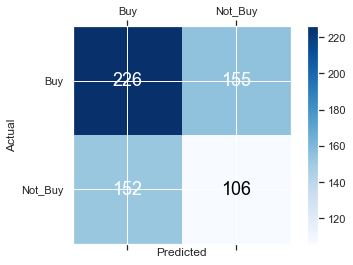

In [6]:
# print classification report
print('--'*27)
print('Baseline Model Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, base_y_pred, target_names = ['Not_Buy', 'Buy']))

# confusion matrix
print('--'*27)
print('Baseline Confusion Matrix')
print('--'*27)
base_cm = confusion_matrix(y_test, base_y_pred, labels = [1,0])
base_classes = ['Buy', 'Not_Buy']
plot_confusion_matrix(base_cm, base_classes)

### Examine ROC Curve

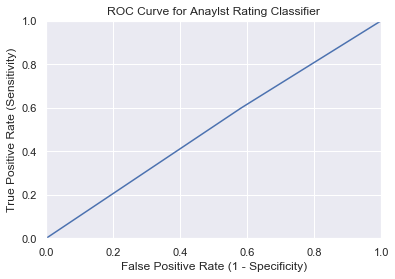

In [7]:
# store the predicted probabilities for class 1
base_y_pred_prob = base.predict_proba(X_test)[:, 1]

# plot the ROC cure
plot_ROC_curve(y_test, base_y_pred_prob)

## Logistic Regression (Log Reg)

In [8]:
# instantiate classifier, fit model, make predict
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
log_y_pred = logreg.predict(X_test)

------------------------------------------------------
Log Reg Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

     Not_Buy       0.57      0.36      0.44       258
         Buy       0.65      0.81      0.73       381

    accuracy                           0.63       639
   macro avg       0.61      0.59      0.58       639
weighted avg       0.62      0.63      0.61       639

------------------------------------------------------
Log Reg Confusion Matrix
------------------------------------------------------


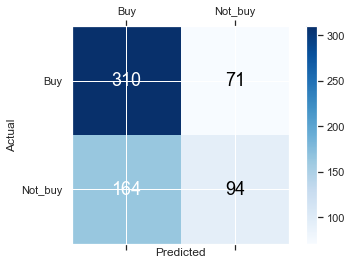

In [9]:
# print classification report
print('--'*27)
print('Log Reg Model Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, log_y_pred, target_names = ['Not_Buy', 'Buy']))

# confusion matrix
print('--'*27)
print('Log Reg Confusion Matrix')
print('--'*27)
log_cm = confusion_matrix(y_test, log_y_pred, labels = [1,0])
log_classes = ['Buy', 'Not_buy']
plot_confusion_matrix(log_cm, log_classes)

### Print Log Reg Model

In [10]:
dictionary = dict(zip(list(X_train.columns), list(logreg.coef_[0])))

print('Logistic Regression Model:')
print('--'*27)
print(f'Intercept: {logreg.intercept_[0] : 0.3}\n')
print(f'Coefficients: ')

coefficients = list(dictionary.values())

for i, coefficient in enumerate(dictionary):
    print(f'  {coefficient} = {list(dictionary.values())[i] : 0.3}')

Logistic Regression Model:
------------------------------------------------------
Intercept:  0.426

Coefficients: 
  dividend_payout_ratio = -0.311
  forward_eps = -0.0025
  g_revenue =  0.0319
  price_to_forward_earnings = -0.086
  price_to_book =  0.0679
  debt_to_equity = -0.439
  return_on_assets = -0.332
  return_on_equity =  0.16
  gross_margin =  0.172
  ebitda_margin = -0.18
  fifty_two =  0.22
  log_mktcap =  0.55


## K Nearest Neighbors (KNN)

In [11]:
# find the optimal k
best_k = 0
best_score = 0
neighbors = range(1,10,2) # will consider min_k = 1, max_k = 25, only odds in between
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k) # instantiate classifier
    knn.fit(X_train, y_train) # fit model
    knn_y_pred = knn.predict(X_test) # make a prediction
    
    # we will consider the optimal K to be the K that produces the highest precision score 
    f1 = metrics.f1_score(y_test, knn_y_pred) 
    if f1 > best_score:
        best_k = k
        best_score = f1

# instantiate the classifier with the optimal K, fit model, and make prediction        
knn = KNeighborsClassifier(n_neighbors = best_k)
knn.fit(X_train, y_train)
best_knn_pred = knn.predict(X_test)

------------------------------------------------------
KNN Model Classification Report, Optimal K = 9
------------------------------------------------------
              precision    recall  f1-score   support

     Not_Buy       0.61      0.45      0.51       258
         Buy       0.68      0.80      0.74       381

    accuracy                           0.66       639
   macro avg       0.64      0.62      0.63       639
weighted avg       0.65      0.66      0.65       639


------------------------------------------------------
KNN Confusion Matrix
------------------------------------------------------


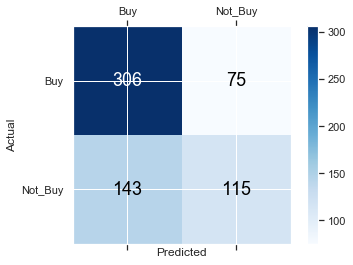

In [12]:
# print classification report
print('--'*27)
print(f'KNN Model Classification Report, Optimal K = {best_k}')
print('--'*27)
print(metrics.classification_report(y_test, best_knn_pred, target_names = ['Not_Buy', 'Buy']))
print('')

# confusion matrix
print('--'*27)
print('KNN Confusion Matrix')
print('--'*27)
knn_cm = confusion_matrix(y_test, knn_y_pred, labels=[1,0])
knn_classes = ['Buy', 'Not_Buy']
plot_confusion_matrix(knn_cm, knn_classes)

### Examine the ROC curve for the model

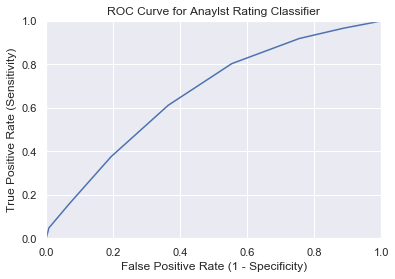

In [13]:
# store the predicted probabilities for class 1
knn_y_pred_prob = knn.predict_proba(X_test)[:, 1]

# plot the ROC cure
plot_ROC_curve(y_test, knn_y_pred_prob)

## Decision Tree Model (DTM)

In [14]:
# create param grid for GridSearch
dtm_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

# instantiate GridSearchCV
dtm_grid_search = GridSearchCV(
    DecisionTreeClassifier(
        random_state = 42
    ),
    scoring = 'f1',
    param_grid = dtm_param_grid
)

In [15]:
# fit model and make prediction
dtm_grid_search.fit(X_train, y_train)
dtm_y_pred = dtm_grid_search.predict(X_test)

------------------------------------------------------
DTM Optimal Parameters
------------------------------------------------------
 criterion = gini
 max_depth = 2
 min_samples_leaf = 1
 min_samples_split = 2
------------------------------------------------------
DTM Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

     Not_Buy       0.47      0.50      0.49       258
         Buy       0.65      0.62      0.63       381

    accuracy                           0.57       639
   macro avg       0.56      0.56      0.56       639
weighted avg       0.58      0.57      0.57       639

------------------------------------------------------
DTM Confusion Matrix
------------------------------------------------------


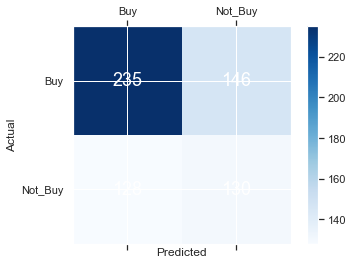

In [16]:
# print optimal paramas
print('--'*27)
print('DTM Optimal Parameters')
print('--'*27)
dtm_best_params = dtm_grid_search.best_params_
for i, param in enumerate(dtm_best_params):
    print(f' {param} = {list(dtm_best_params.values())[i]}')

# print classification report
print('--'*27)
print('DTM Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, dtm_y_pred, target_names = ['Not_Buy', 'Buy']))

# confusion matrix
print('--'*27)
print('DTM Confusion Matrix')
print('--'*27)
dtm_cm = confusion_matrix(y_test, dtm_y_pred, labels = [1,0])
dtm_classes = ['Buy', 'Not_Buy']
plot_confusion_matrix(dtm_cm, dtm_classes)

### Examine the Feature Importances and ROC curve

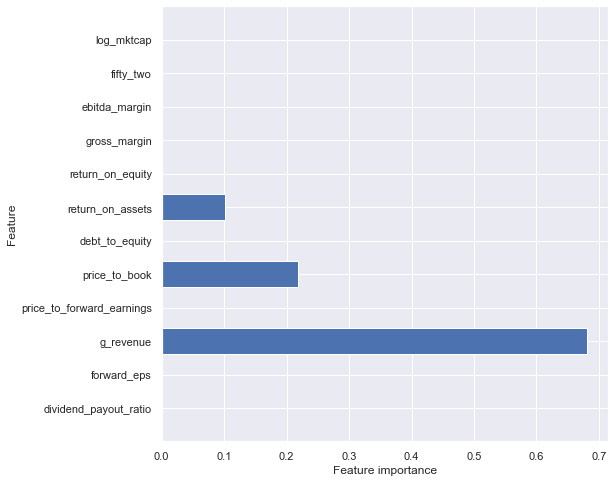

In [17]:
# feature importance
optimized_dtm = DecisionTreeClassifier(
    criterion = dtm_best_params['criterion'],
    max_depth = dtm_best_params['max_depth'],
    min_samples_leaf = dtm_best_params['min_samples_leaf'],
    min_samples_split = dtm_best_params['min_samples_split'],
    random_state = 42
)

optimized_dtm.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, optimized_dtm, n_features)

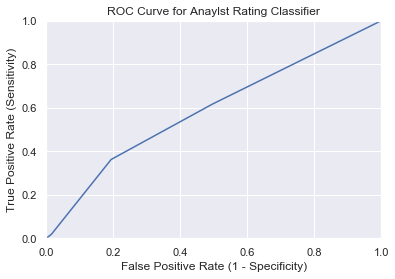

In [18]:
# store the predicted probabilities for class 1
dtm_y_pred_prob = dtm_grid_search.predict_proba(X_test)[:, 1]

# plot the ROC curve
plot_ROC_curve(y_test, dtm_y_pred_prob)

## Random Forest Model (RF)

In [19]:
# create param grid for GridSearch
rf_param_grid = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

# instantiate GridSearchCV
rf_grid_search = GridSearchCV(
    RandomForestClassifier(
        random_state = 42),
    param_grid = rf_param_grid
)

In [20]:
# fit model and make prediction
rf_grid_search.fit(X_train, y_train)
rf_y_pred = rf_grid_search.predict(X_test)

------------------------------------------------------
RF Optimal Parameters
------------------------------------------------------
 criterion = entropy
 max_depth = 10
 min_samples_leaf = 3
 min_samples_split = 10
 n_estimators = 50
------------------------------------------------------
RF Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

     Not_Buy       0.62      0.49      0.55       258
         Buy       0.70      0.80      0.74       381

    accuracy                           0.67       639
   macro avg       0.66      0.64      0.65       639
weighted avg       0.67      0.67      0.66       639

------------------------------------------------------
RF Confusion Matrix
------------------------------------------------------


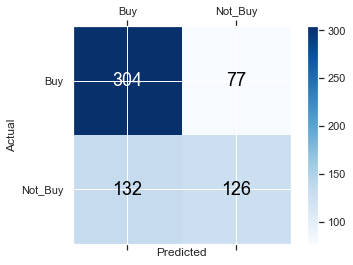

In [21]:
# print optimal paramas
print('--'*27)
print('RF Optimal Parameters')
print('--'*27)
rf_best_params = rf_grid_search.best_params_
for i, param in enumerate(rf_best_params):
    print(f' {param} = {list(rf_best_params.values())[i]}')

# print classification report
print('--'*27)
print('RF Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, rf_y_pred, target_names = ['Not_Buy', 'Buy']))

# confusion matrix
print('--'*27)
print('RF Confusion Matrix')
print('--'*27)
rf_cm = confusion_matrix(y_test, rf_y_pred, labels = [1,0])
rf_classes = ['Buy', 'Not_Buy']
plot_confusion_matrix(rf_cm, rf_classes)

### Examine the Feature Importances and ROC curve

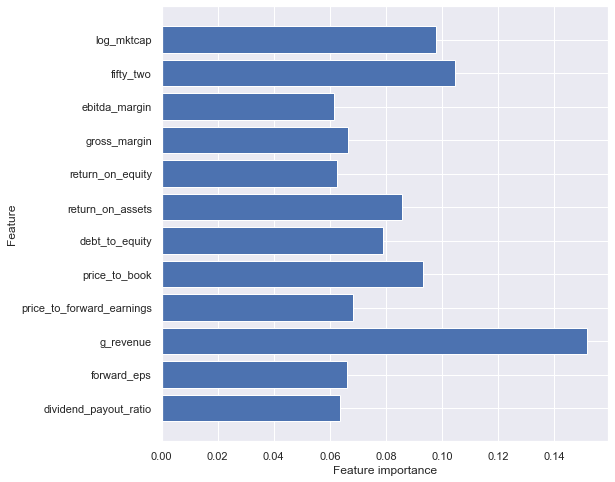

In [22]:
# feature importance
optimized_rf = RandomForestClassifier(
    criterion = rf_best_params['criterion'],
    max_depth = rf_best_params['max_depth'],
    min_samples_leaf = rf_best_params['min_samples_leaf'],
    min_samples_split = rf_best_params['min_samples_split'],
    n_estimators = rf_best_params['n_estimators'],
    random_state = 42
)

optimized_rf.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, optimized_rf, n_features)

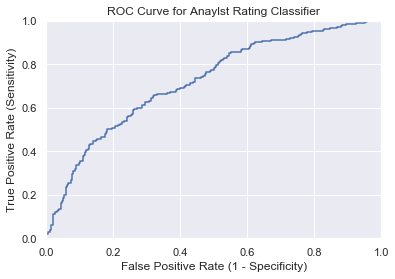

In [23]:
# ROC curve
rf_y_pred_prob = rf_grid_search.predict_proba(X_test)[:, 1]

plot_ROC_curve(y_test, rf_y_pred_prob)

## AdaBoost (ABC)

In [24]:
# define param grid
abc_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.2]
}

# instantiate GridSearchCV, fit model, and make prediction
abc_grid_search = GridSearchCV(
    AdaBoostClassifier(
        random_state = 42
    ),
    param_grid = abc_param_grid
)

In [25]:
# fit model and make prediction
abc_grid_search.fit(X_train, y_train)
abc_y_pred = abc_grid_search.predict(X_test)

------------------------------------------------------
ABC Optimal Parameters
------------------------------------------------------
 learning_rate = 0.2
 n_estimators = 100
------------------------------------------------------
ABC Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

     Not_Buy       0.59      0.42      0.49       258
         Buy       0.67      0.80      0.73       381

    accuracy                           0.65       639
   macro avg       0.63      0.61      0.61       639
weighted avg       0.64      0.65      0.64       639

------------------------------------------------------
ABC Confusion Matrix
------------------------------------------------------


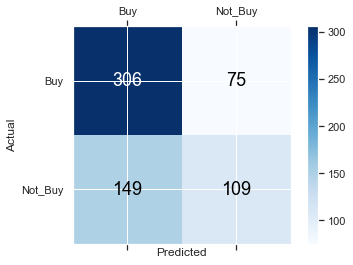

In [26]:
# print optimal paramas
print('--'*27)
print('ABC Optimal Parameters')
print('--'*27)
abc_best_params = abc_grid_search.best_params_
for i, param in enumerate(abc_best_params):
    print(f' {param} = {list(abc_best_params.values())[i]}')

# print classification report
print('--'*27)
print('ABC Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, abc_y_pred, target_names = ['Not_Buy', 'Buy']))

# confusion matrix
print('--'*27)
print('ABC Confusion Matrix')
print('--'*27)
abc_cm = confusion_matrix(y_test, abc_y_pred, labels = [1,0])
abc_classes = ['Buy', 'Not_Buy']
plot_confusion_matrix(abc_cm, abc_classes)

### Examine the Feature Importances and ROC curve

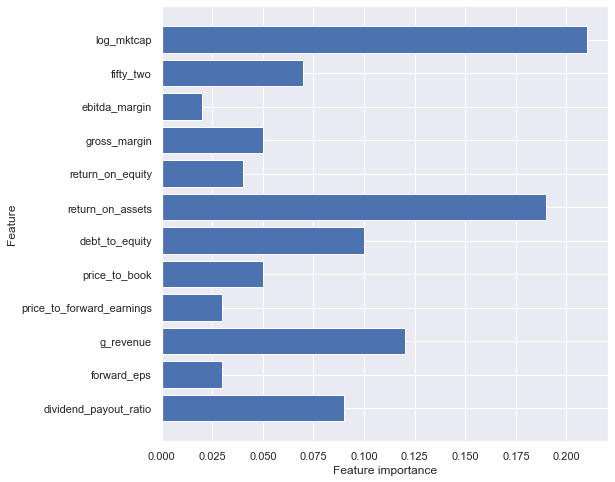

In [27]:
# feature importance
optimized_abc = AdaBoostClassifier(
    learning_rate = abc_best_params['learning_rate'],
    n_estimators = abc_best_params['n_estimators'],
    random_state = 42
)

optimized_abc.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, optimized_abc, n_features)

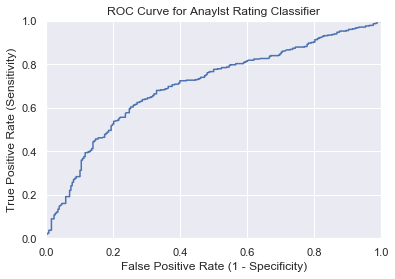

In [28]:
# ROC curve
abc_y_pred_prob = abc_grid_search.predict_proba(X_test)[:, 1]

plot_ROC_curve(y_test, abc_y_pred_prob)

## Gradient Boosting (GB)

In [29]:
# define param grid
gb_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.2]
}

# instantiate GridSearchCV
gb_grid_search = GridSearchCV(
    GradientBoostingClassifier(
        max_depth = 1,
        random_state = 42
    ),
    param_grid=gb_param_grid
)

In [30]:
# fit model and make prediction
gb_grid_search.fit(X_train, y_train)
gb_y_pred = gb_grid_search.predict(X_test)

------------------------------------------------------
GB Optimal Parameters
------------------------------------------------------
 learning_rate = 0.1
 n_estimators = 100
------------------------------------------------------
GB Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

     Not_Buy       0.57      0.38      0.45       258
         Buy       0.66      0.80      0.72       381

    accuracy                           0.63       639
   macro avg       0.61      0.59      0.59       639
weighted avg       0.62      0.63      0.61       639

------------------------------------------------------
GB Confusion Matrix
------------------------------------------------------


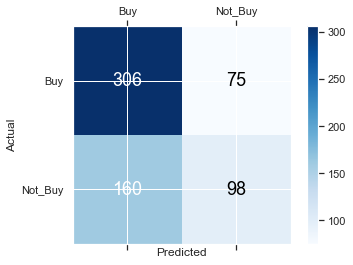

In [31]:
# print optimal paramas
print('--'*27)
print('GB Optimal Parameters')
print('--'*27)
gb_best_params = gb_grid_search.best_params_
for i, param in enumerate(gb_best_params):
    print(f' {param} = {list(gb_best_params.values())[i]}')

# print classification report
print('--'*27)
print('GB Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, gb_y_pred, target_names = ['Not_Buy', 'Buy']))

# confusion matrix
print('--'*27)
print('GB Confusion Matrix')
print('--'*27)
gb_cm = confusion_matrix(y_test, gb_y_pred, labels = [1,0])
gb_classes = ['Buy', 'Not_Buy']
plot_confusion_matrix(gb_cm, gb_classes)

### Examine the Feature Importances and ROC curve

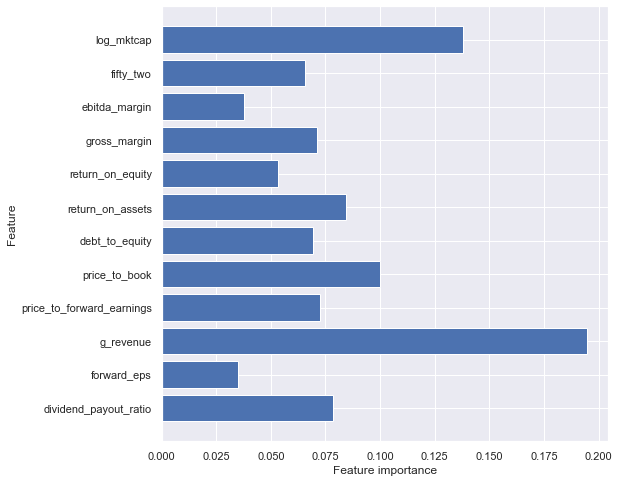

In [32]:
# feature importance
optimized_gb = GradientBoostingClassifier(
    learning_rate = gb_best_params['learning_rate'],
    n_estimators = gb_best_params['n_estimators'],
    random_state = 42
)

optimized_gb.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, optimized_gb, n_features)

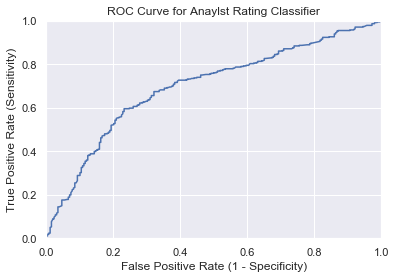

In [33]:
# ROC curve
gb_y_pred_prob = gb_grid_search.predict_proba(X_test)[:, 1]

plot_ROC_curve(y_test, gb_y_pred_prob)

## XGBoost (XGB)

In [34]:
# define param grid
xgb_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.2],
    'max_depth': [1, 2, 5, 10],
}

# instantiate GridSearchCV
xgb_grid_search = GridSearchCV(
    XGBClassifier(
        max_depth = 1,
        random_state = 42
    ),
    scoring = 'f1',
    param_grid = xgb_param_grid
)

In [35]:
# fit model and make prediction
xgb_grid_search.fit(X_train, y_train)
xgb_y_pred = gb_grid_search.predict(X_test)

------------------------------------------------------
XGB Optimal Parameters
------------------------------------------------------
 learning_rate = 0.1
 max_depth = 1
 n_estimators = 50
------------------------------------------------------
XGB Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

     Not_Buy       0.57      0.38      0.45       258
         Buy       0.66      0.80      0.72       381

    accuracy                           0.63       639
   macro avg       0.61      0.59      0.59       639
weighted avg       0.62      0.63      0.61       639

------------------------------------------------------
XGB Confusion Matrix
------------------------------------------------------


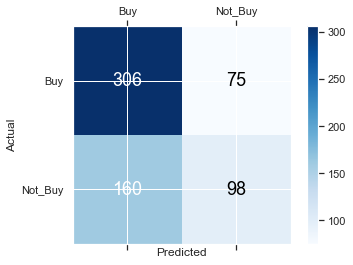

In [36]:
# print optimal paramas
print('--'*27)
print('XGB Optimal Parameters')
print('--'*27)
xgb_best_params = xgb_grid_search.best_params_
for i, param in enumerate(xgb_best_params):
    print(f' {param} = {list(xgb_best_params.values())[i]}')

# print classification report
print('--'*27)
print('XGB Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, xgb_y_pred, target_names = ['Not_Buy', 'Buy']))

# confusion matrix
print('--'*27)
print('XGB Confusion Matrix')
print('--'*27)
xgb_cm = confusion_matrix(y_test, xgb_y_pred, labels = [1,0])
xgb_classes = ['Buy', 'Not_Buy']
plot_confusion_matrix(xgb_cm, xgb_classes)

### Examine the Feature Importances and ROC curve

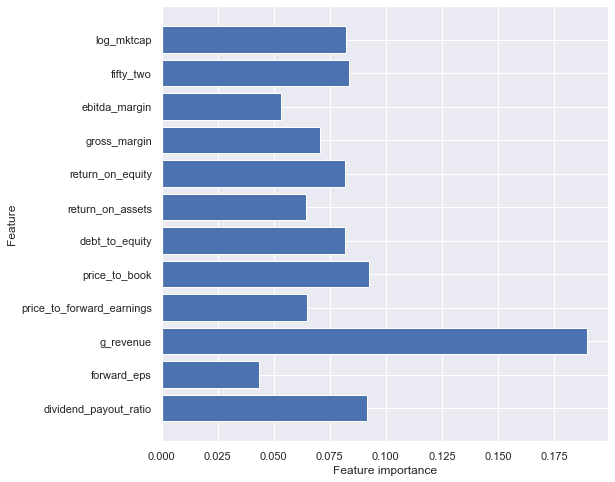

In [37]:
# feature importance
optimized_gb = XGBClassifier(
    learning_rate = xgb_best_params['learning_rate'],
    n_estimators = xgb_best_params['n_estimators']
)

optimized_gb.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, optimized_gb, n_features)

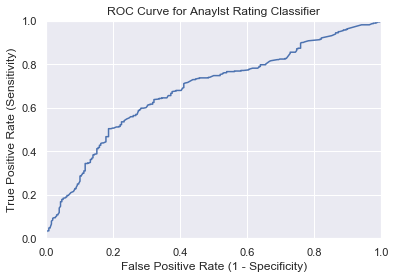

In [38]:
# ROC curve
xgb_y_pred_prob = xgb_grid_search.predict_proba(X_test)[:, 1]

plot_ROC_curve(y_test, xgb_y_pred_prob)

## Support Vector Classifier (SVC)

In [39]:
# define param grid
svc_param_grid = {
    'kernel' : ['linear', 'poly', 'rbf'],
    'C' : [0.001, 0.01, 0.1, 1, 10],
    'gamma' : [0.001, 0.01, 0.1, 1],
}

# instantiate classifier
svc_grid_search = GridSearchCV(
    SVC(
        probability = True,
        random_state = 42
    ),
    param_grid = svc_param_grid
)

In [40]:
# fit model and make prediction
svc_grid_search.fit(X_train, y_train)
svc_y_pred = svc_grid_search.predict(X_test)

------------------------------------------------------
SVC Optimal Parameters
------------------------------------------------------
 C = 1
 gamma = 0.1
 kernel = rbf
------------------------------------------------------
SVC Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

     Not_Buy       0.67      0.34      0.45       258
         Buy       0.66      0.89      0.76       381

    accuracy                           0.67       639
   macro avg       0.67      0.61      0.61       639
weighted avg       0.67      0.67      0.64       639

------------------------------------------------------
SVC Confusion Matrix
------------------------------------------------------


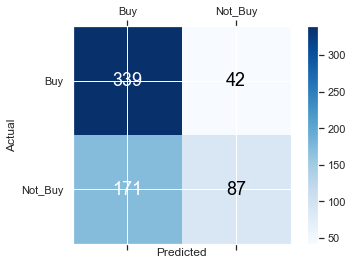

In [41]:
# print optimal paramas
print('--'*27)
print('SVC Optimal Parameters')
print('--'*27)
svc_best_params = svc_grid_search.best_params_
for i, param in enumerate(svc_best_params):
    print(f' {param} = {list(svc_best_params.values())[i]}')

# print classification report
print('--'*27)
print('SVC Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, svc_y_pred, target_names = ['Not_Buy', 'Buy']))

# confusion matrix
print('--'*27)
print('SVC Confusion Matrix')
print('--'*27)
svc_cm = confusion_matrix(y_test, svc_y_pred, labels = [1,0])
svc_classes = ['Buy', 'Not_Buy']
plot_confusion_matrix(svc_cm, svc_classes)

### Examine the ROC curve

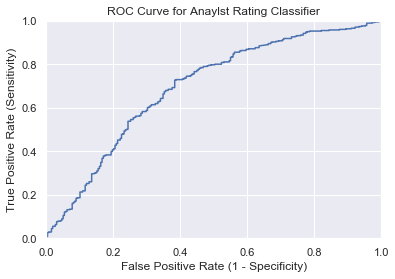

In [42]:
# ROC curve
svc_y_pred_prob = svc_grid_search.predict_proba(X_test)[:, 1]

plot_ROC_curve(y_test, svc_y_pred_prob)

## Build a Summary Table

In [43]:
print('-'*64)
print('|   Baseline Model   |    LogicRegress    |   KNearNeighbors   |')
print(f'| Accuracy:  {metrics.accuracy_score(y_test, base_y_pred) : 0.2%} | Accuracy:  {metrics.accuracy_score(y_test, log_y_pred) : 0.2%} | Accuracy:  {metrics.accuracy_score(y_test, knn_y_pred) : 0.2%} |')
print(f'| Precision: {metrics.precision_score(y_test, base_y_pred) : 0.2%} | Precision: {metrics.precision_score(y_test, log_y_pred) : 0.2%} | Precision: {metrics.precision_score(y_test, knn_y_pred) : 0.2%} |')
print(f'| Recall:    {metrics.recall_score(y_test, base_y_pred) : 0.2%} | Recall:    {metrics.recall_score(y_test, log_y_pred) : 0.2%} | Recall:    {metrics.recall_score(y_test, knn_y_pred) : 0.2%} |')
print(f'| F1 Score:  {metrics.f1_score(y_test, base_y_pred) : 0.2%} | F1 Score:  {metrics.f1_score(y_test, log_y_pred) : 0.2%} | F1 Score:  {metrics.f1_score(y_test, knn_y_pred) : 0.2%} |')
print('-'*64)
print('|    DecisionTree    |    RandomForest    |      AdaBoost      |')
print(f'| Accuracy:  {metrics.accuracy_score(y_test, dtm_y_pred) : 0.2%} | Accuracy:  {metrics.accuracy_score(y_test, rf_y_pred) : 0.2%} | Accuracy:  {metrics.accuracy_score(y_test, abc_y_pred) : 0.2%} |')
print(f'| Precision: {metrics.precision_score(y_test, dtm_y_pred) : 0.2%} | Precision: {metrics.precision_score(y_test, rf_y_pred) : 0.2%} | Precision: {metrics.precision_score(y_test, abc_y_pred) : 0.2%} |')
print(f'| Recall:    {metrics.recall_score(y_test, dtm_y_pred) : 0.2%} | Recall:    {metrics.recall_score(y_test, rf_y_pred) : 0.2%} | Recall:    {metrics.recall_score(y_test, abc_y_pred) : 0.2%} |')
print(f'| F1 Score:  {metrics.f1_score(y_test, dtm_y_pred) : 0.2%} | F1 Score:  {metrics.f1_score(y_test, rf_y_pred) : 0.2%} | F1 Score:  {metrics.f1_score(y_test, abc_y_pred) : 0.2%} |')
print('-'*64)
print('|   Gradient_Boost   |      XG_Boost      |    Sup_Vector_M    |')
print(f'| Accuracy:  {metrics.accuracy_score(y_test, gb_y_pred) : 0.2%} | Accuracy:  {metrics.accuracy_score(y_test, xgb_y_pred) : 0.2%} | Accuracy:  {metrics.accuracy_score(y_test, svc_y_pred) : 0.2%} |')
print(f'| Precision: {metrics.precision_score(y_test, gb_y_pred) : 0.2%} | Precision: {metrics.precision_score(y_test, xgb_y_pred) : 0.2%} | Precision: {metrics.precision_score(y_test, svc_y_pred) : 0.2%} |')
print(f'| Recall:    {metrics.recall_score(y_test, gb_y_pred) : 0.2%} | Recall:    {metrics.recall_score(y_test, xgb_y_pred) : 0.2%} | Recall:    {metrics.recall_score(y_test, svc_y_pred) : 0.2%} |')
print(f'| F1 Score:  {metrics.f1_score(y_test, gb_y_pred) : 0.2%} | F1 Score:  {metrics.f1_score(y_test, xgb_y_pred) : 0.2%} | F1 Score:  {metrics.f1_score(y_test, svc_y_pred) : 0.2%} |')
print('-'*64)

----------------------------------------------------------------
|   Baseline Model   |    LogicRegress    |   KNearNeighbors   |
| Accuracy:   51.96% | Accuracy:   63.22% | Accuracy:   65.88% |
| Precision:  59.79% | Precision:  65.40% | Precision:  68.15% |
| Recall:     59.32% | Recall:     81.36% | Recall:     80.31% |
| F1 Score:   59.55% | F1 Score:   72.51% | F1 Score:   73.73% |
----------------------------------------------------------------
|    DecisionTree    |    RandomForest    |      AdaBoost      |
| Accuracy:   57.12% | Accuracy:   67.29% | Accuracy:   64.95% |
| Precision:  64.74% | Precision:  69.72% | Precision:  67.25% |
| Recall:     61.68% | Recall:     79.79% | Recall:     80.31% |
| F1 Score:   63.17% | F1 Score:   74.42% | F1 Score:   73.21% |
----------------------------------------------------------------
|   Gradient_Boost   |      XG_Boost      |    Sup_Vector_M    |
| Accuracy:   63.22% | Accuracy:   63.22% | Accuracy:   66.67% |
| Precision:  65.67% | Pr